In [1]:
import anndata as ad
import loompy
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import warnings
warnings.filterwarnings('ignore')

/home/arnav/.miniconda3/lib/python3.7/site-packages/anndata/base.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/arnav/.miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Initial setup
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=100,
                     dpi_save=300,
                     vector_friendly=False,
                     transparent=True,
                     format="pdf")
sc.logging.print_versions()

# Output-specific variables
out_stem = "../output_and_analysis/reanalysis/OCM1A-HyPB"
results_file = out_stem + ".h5ad"
raw_file = out_stem + "_raw.h5ad"

scanpy==1.3.7 anndata==0.6.18 numpy==1.17.2 scipy==1.2.1 pandas==1.0.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
sc.logging.print_memory_usage()

Memory usage: current 0.23 GB, difference +0.23 GB


## Preprocessing

In [4]:
# Helper function to process batches
def preprocess_batch(path, barcode_file=None):
    adata = sc.read(path + "matrix.mtx", cache=True).T
    adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
    adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
    adata.var_names_make_unique()
    if barcode_file:
        barcodes = [line.strip() for line in open(barcode_file, 'r')]
        adata = adata[barcodes, :]
    return adata

In [5]:
%%time
# Load the libraries
batch_paths = ["OCM1A-HyPB-scRNA-1_S4_map_cDNA_hg38/outs/filtered_gene_bc_matrices/hg38/",
               "OCM1A-HyPB-scRNA-2_S5_map_cDNA_hg38/outs/filtered_gene_bc_matrices/hg38/",
               "OCM1A-HyPB-scRNA-3_S6_map_cDNA_hg38/outs/filtered_gene_bc_matrices/hg38/",]
barcode_files = ["OCM1A-HyPB-1_uniqBarcodes.txt",
                 "OCM1A-HyPB-2_uniqBarcodes.txt",
                 "OCM1A-HyPB-3_uniqBarcodes.txt",]
batch_names = ["0", "1", "2",]
batches = [preprocess_batch(path, barcode_file = barcodes) for path, barcodes in zip(batch_paths, barcode_files)]

... reading from cache file ./cache/OCM1A-HyPB-scRNA-1_S4_map_cDNA_hg38-outs-filtered_gene_bc_matrices-hg38-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... reading from cache file ./cache/OCM1A-HyPB-scRNA-2_S5_map_cDNA_hg38-outs-filtered_gene_bc_matrices-hg38-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... reading from cache file ./cache/OCM1A-HyPB-scRNA-3_S6_map_cDNA_hg38-outs-filtered_gene_bc_matrices-hg38-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 10.8 s, sys: 1.45 s, total: 12.2 s
Wall time: 5.17 s


In [6]:
# Concatenate batches
raw_adata = ad.AnnData.concatenate(*batches, batch_categories=batch_names, index_unique=None)
# We can specify index_unique = None because we have prefiltered with barcode_files

## Process scRNA-seq data

### Find highly variable genes, perform dimensionality reduction

In [7]:
%%time
# Find highly variable genes for dimensionality reduction and projection
sc.pp.filter_genes(raw_adata, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(raw_adata)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(raw_adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=1000,
                                              log=False)

filtered out 8763 genes that are detected in less than 1 counts
CPU times: user 17 s, sys: 1.81 s, total: 18.8 s
Wall time: 3.25 s


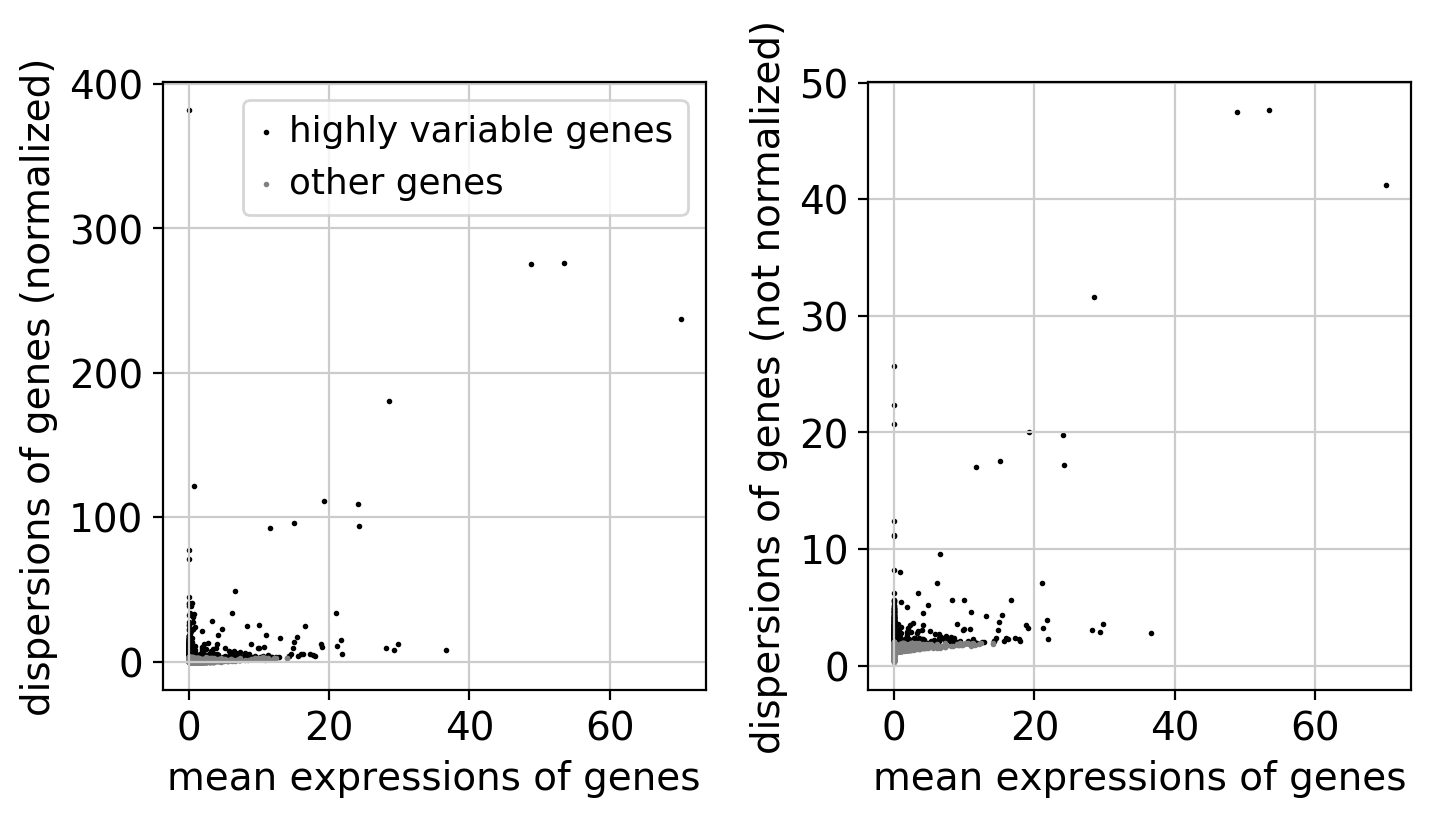

In [8]:
sc.pl.filter_genes_dispersion(filter_result, log=True)

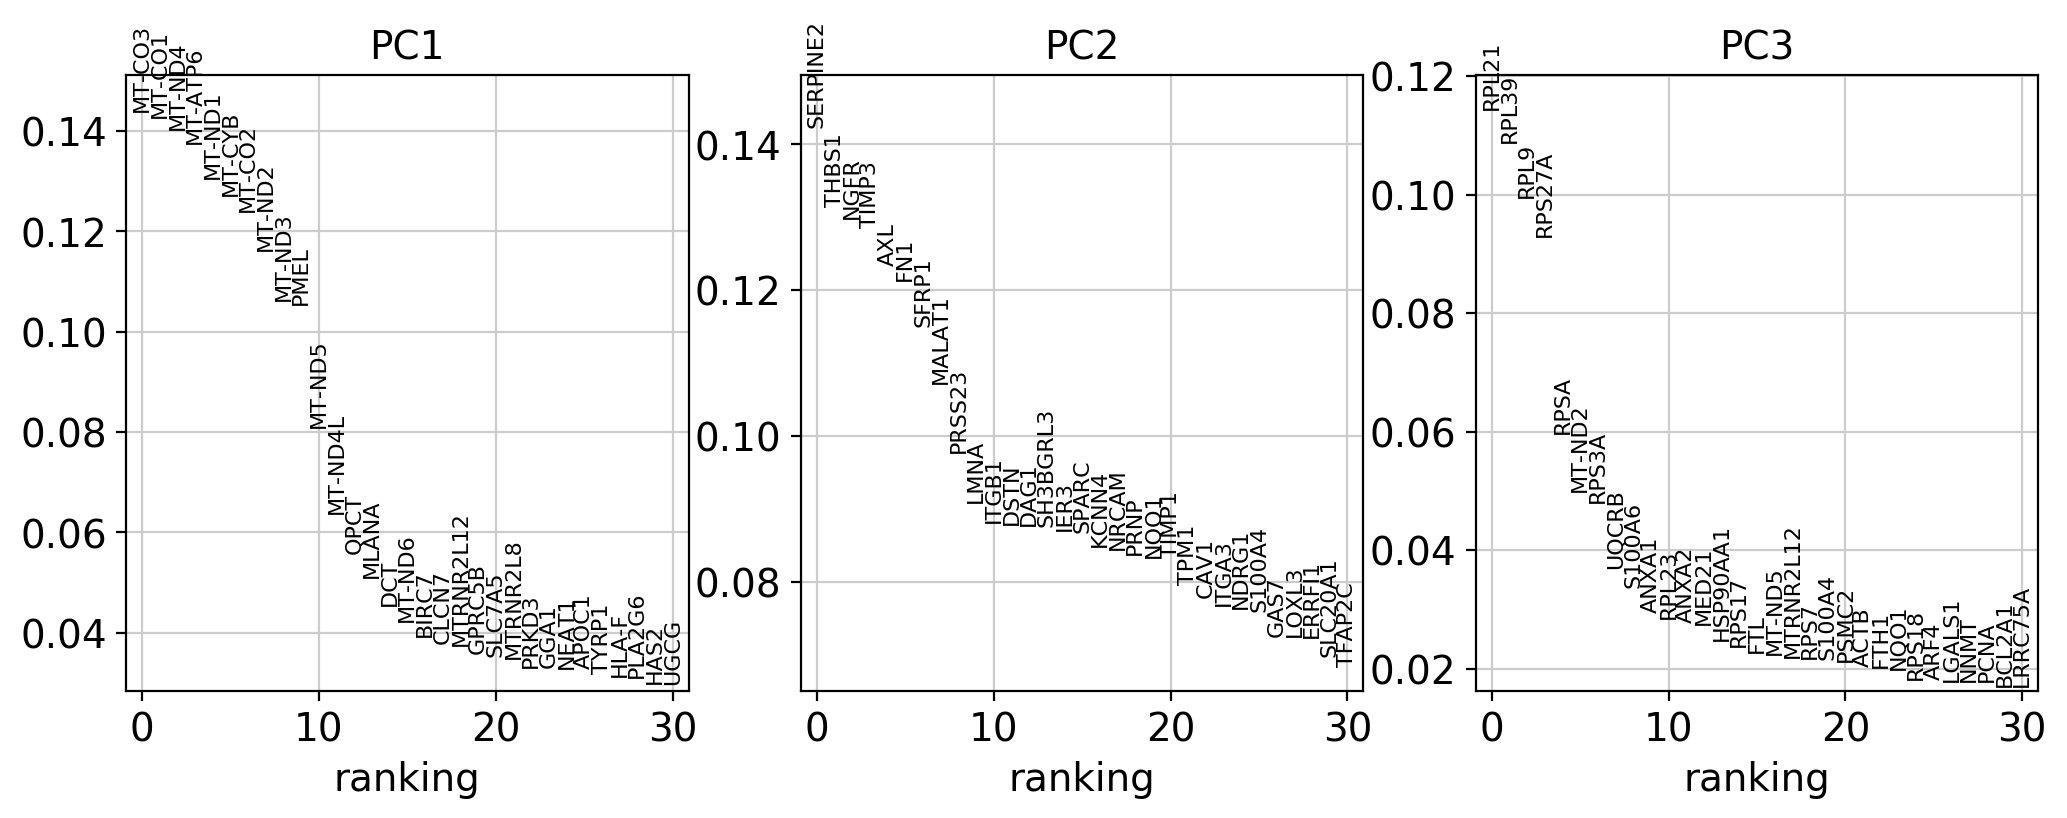

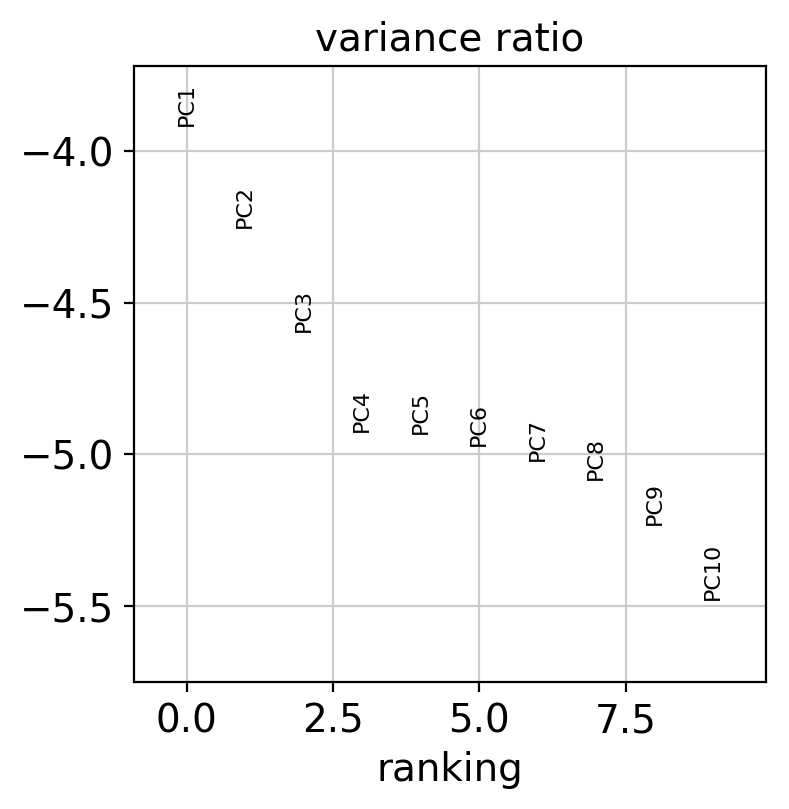

Memory usage: current 1.59 GB, difference +1.35 GB
CPU times: user 14.3 s, sys: 981 ms, total: 15.3 s
Wall time: 2.94 s


In [9]:
%%time
# Reduce dimensions and project with highly variable genes
raw_umap = raw_adata[:, filter_result.gene_subset]  # filter genes
sc.pp.normalize_per_cell(raw_umap)  # need to redo normalization after filtering
sc.pp.log1p(raw_umap)  # log transform: X = log(X + 1)
sc.pp.scale(raw_umap)
# PCA. Visualizing variance ratios can help determine an appropriate number of PCs
sc.tl.pca(raw_umap, n_comps=10, svd_solver="arpack")
sc.pl.pca_loadings(raw_umap)
sc.pl.pca_variance_ratio(raw_umap, log=True)
sc.logging.print_memory_usage()

In [10]:
%%time
# Calculate neighborhood graph
sc.pp.neighbors(raw_umap, n_pcs=10)
sc.logging.print_memory_usage()

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:12.43) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Memory usage: current 1.60 GB, difference +0.02 GB
CPU times: user 21.2 s, sys: 2.06 s, total: 23.3 s
Wall time: 12.4 s


computing UMAP
    finished (0:00:24.36) --> added
    'X_umap', UMAP coordinates (adata.obsm)


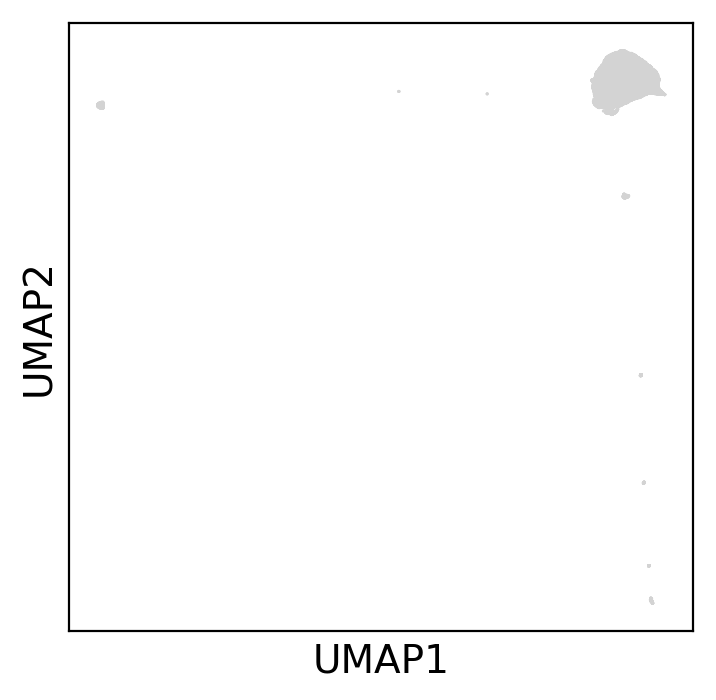

Memory usage: current 1.61 GB, difference +0.01 GB
CPU times: user 34.5 s, sys: 691 ms, total: 35.2 s
Wall time: 24.9 s


In [11]:
%%time
# Create the projection
sc.tl.umap(raw_umap, min_dist=0.1) # 0.1 default from umap-learn, leads to tighter clusters
# Plot the projection
sc.pl.umap(raw_umap)
sc.logging.print_memory_usage()

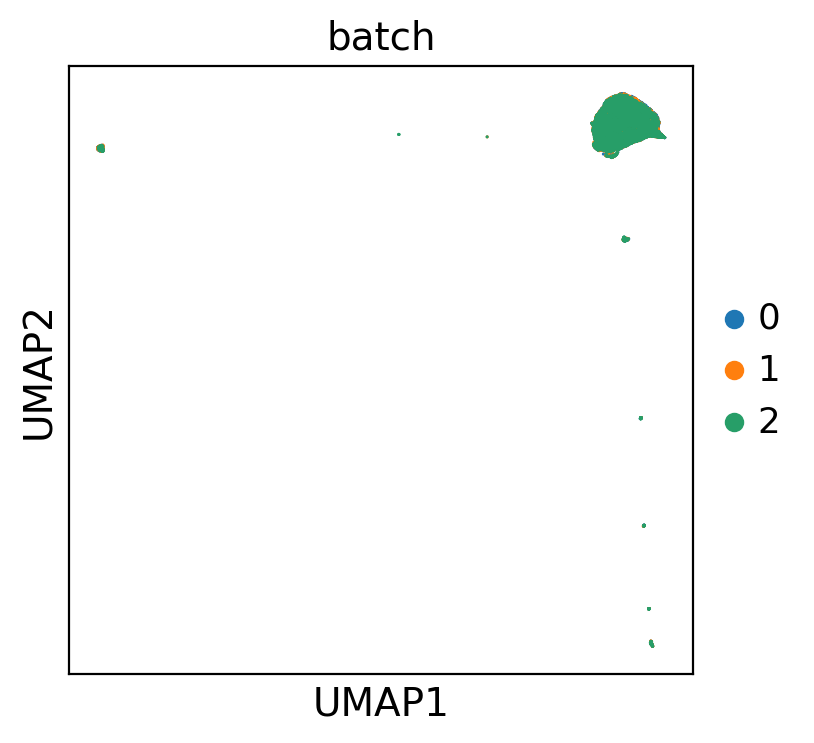

In [12]:
# Save clustering of the uncorrected batches
uncorrected_batch = sc.pl.umap(raw_umap,
                               color="batch",
                               show=False)
uncorrected_batch.figure.savefig(out_stem + "_uncorrected.pdf",
                                 dpi=300,
                                 transparent=True,
                                 bbox_inches="tight")

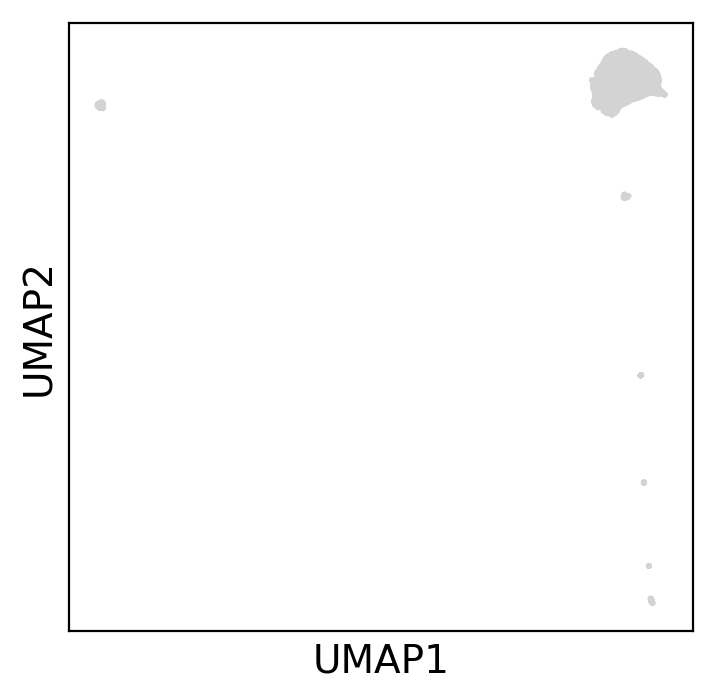

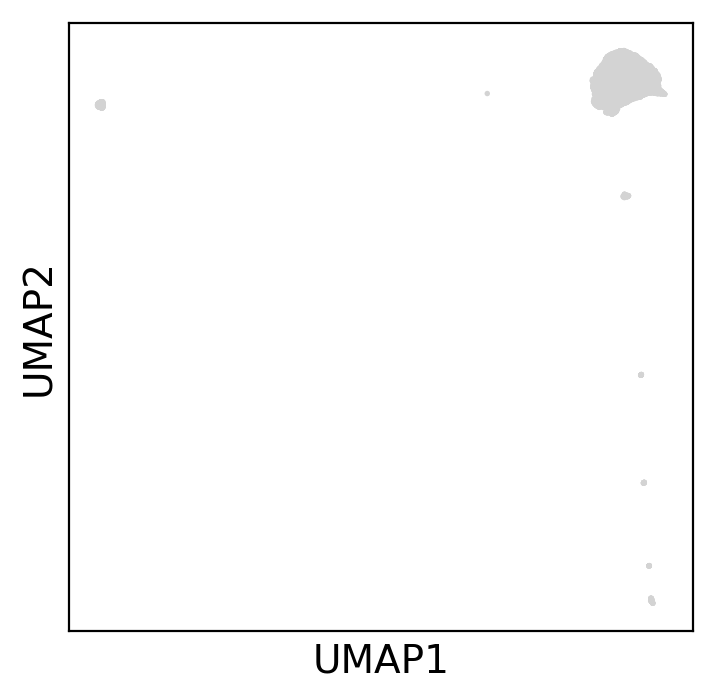

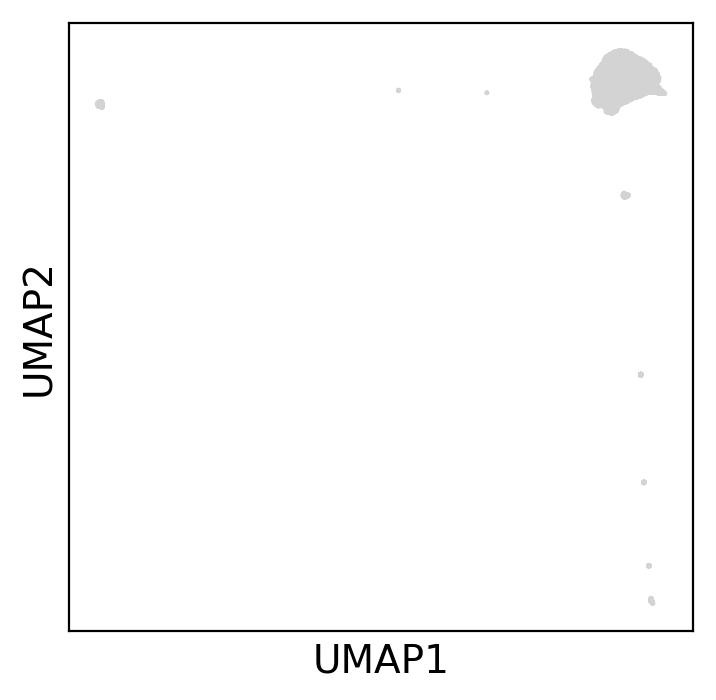

In [13]:
# Plot each batch individually (to visually check batch correction)
for batch in batch_names:
    batch_fig = sc.pl.umap(raw_umap[raw_umap.obs["batch"] == batch], show=False)

In [14]:
# Save the projection to the original raw data structure
raw_adata.obsm = raw_umap.obsm
# Save the raw data
raw_adata.write(raw_file)

### Batch correction

In [15]:
%%time
# Normalize and logarithmize data before batch correction
sc.pp.normalize_per_cell(raw_adata)
sc.pp.log1p(raw_adata)
# Perform batch correction using mutual nearest neighbors (Haghverdi et al. 2018)
correction = sc.pp.mnn_correct(*[raw_adata[raw_adata.obs["batch"] == batch, :] for batch in batch_names],
                               var_subset=raw_adata[:, filter_result.gene_subset].var_names,
                               var_adj=True,
                               save_raw=True,
                               sigma=0.1, # Default in R package scran; 1.0 in mnnpy
                               index_unique=None, # index_unique = None because we have prefiltered with barcode_files
                               n_jobs=16)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.
CPU times: user 1h 20min 45s, sys: 47.4 s, total: 1h 21min 33s
Wall time: 9min 45s


computing neighbors
    finished (0:01:31.80) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:29.15) --> added
    'X_umap', UMAP coordinates (adata.obsm)
CPU times: user 2min 28s, sys: 4.36 s, total: 2min 33s
Wall time: 2min 5s


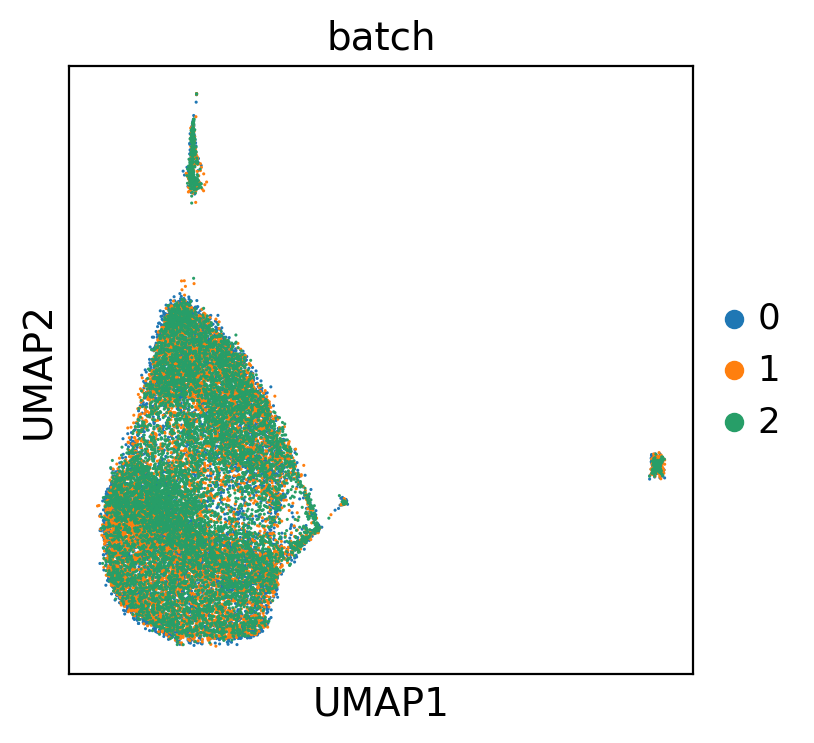

In [16]:
%%time
corr_adata = correction[0]
# # Project the new, batch corrected data
corr_umap = corr_adata[:, filter_result.gene_subset]
# sc.pp.scale(corr_umap) Not scaling the corrected data yields better, more meaningful clustering
sc.pp.neighbors(corr_umap,
                use_rep='X',
                n_neighbors=15) # Default: 15
sc.tl.umap(corr_umap, min_dist=0.1)
# Plot and save the batch corrected clustring
corrected_batch = sc.pl.umap(corr_umap,
                             color="batch",
                             show=False)
corrected_batch.figure.savefig(out_stem + "_corrected.pdf",
                               dpi=300,
                               transparent=True,
                               bbox_inches="tight")

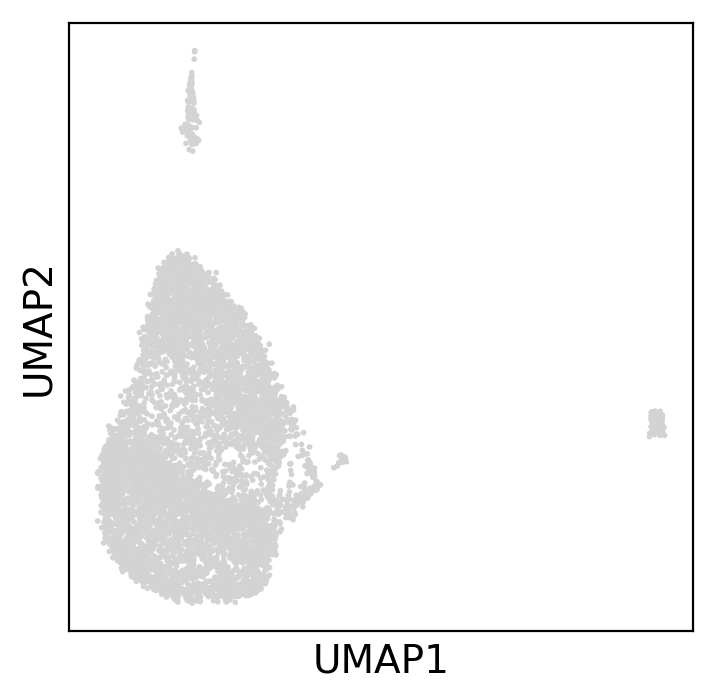

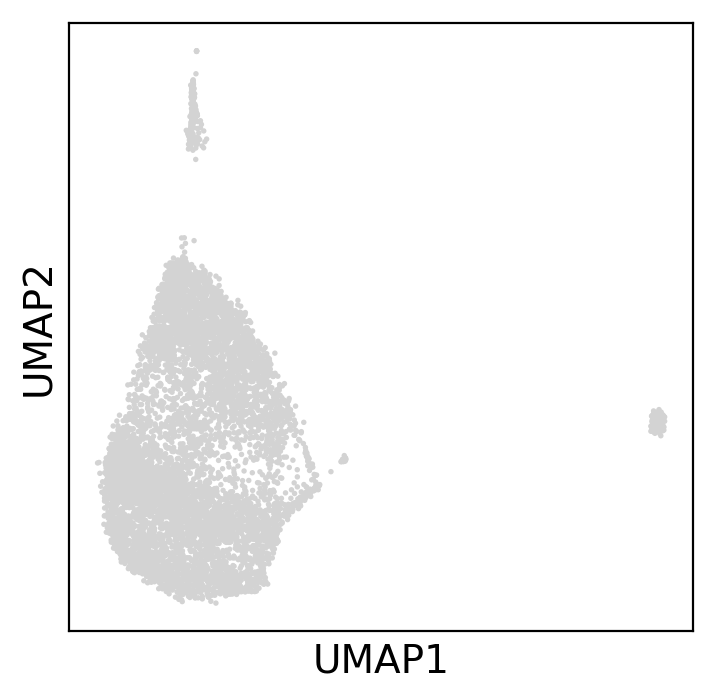

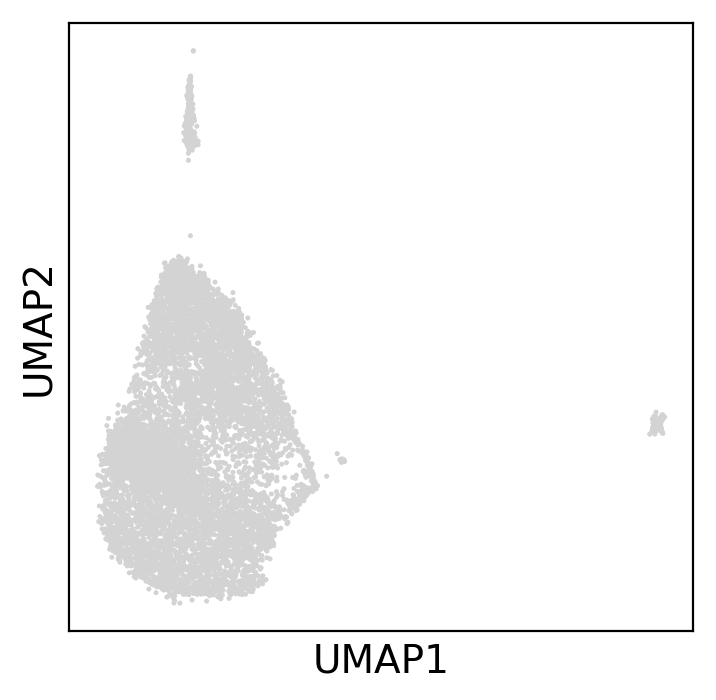

In [17]:
# Plot each batch individually (to visually check batch correction)
for batch in batch_names:
    batch_fig = sc.pl.umap(corr_umap[corr_umap.obs["batch"] == batch], show=False)
    batch_fig.figure.savefig(out_stem + "_batch{}.pdf".format(batch),
                             dpi=300,
                             transparent=True,
                             bbox_inches="tight")

In [18]:
# Save the new projection to the larger dataset
corr_adata.obsm = corr_umap.obsm
# Save file to disk
corr_adata.write(results_file)

## Explore the data

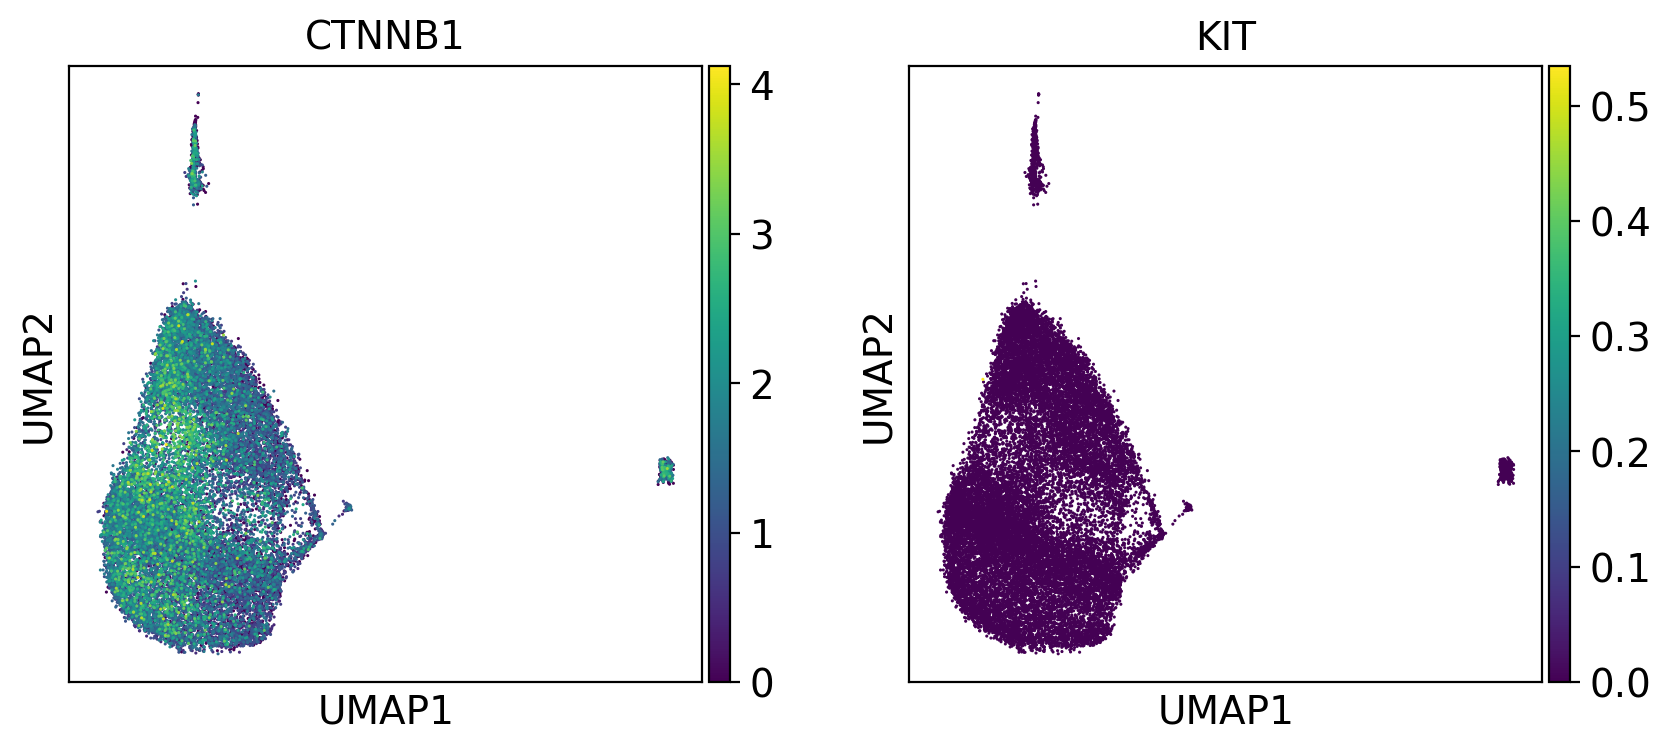

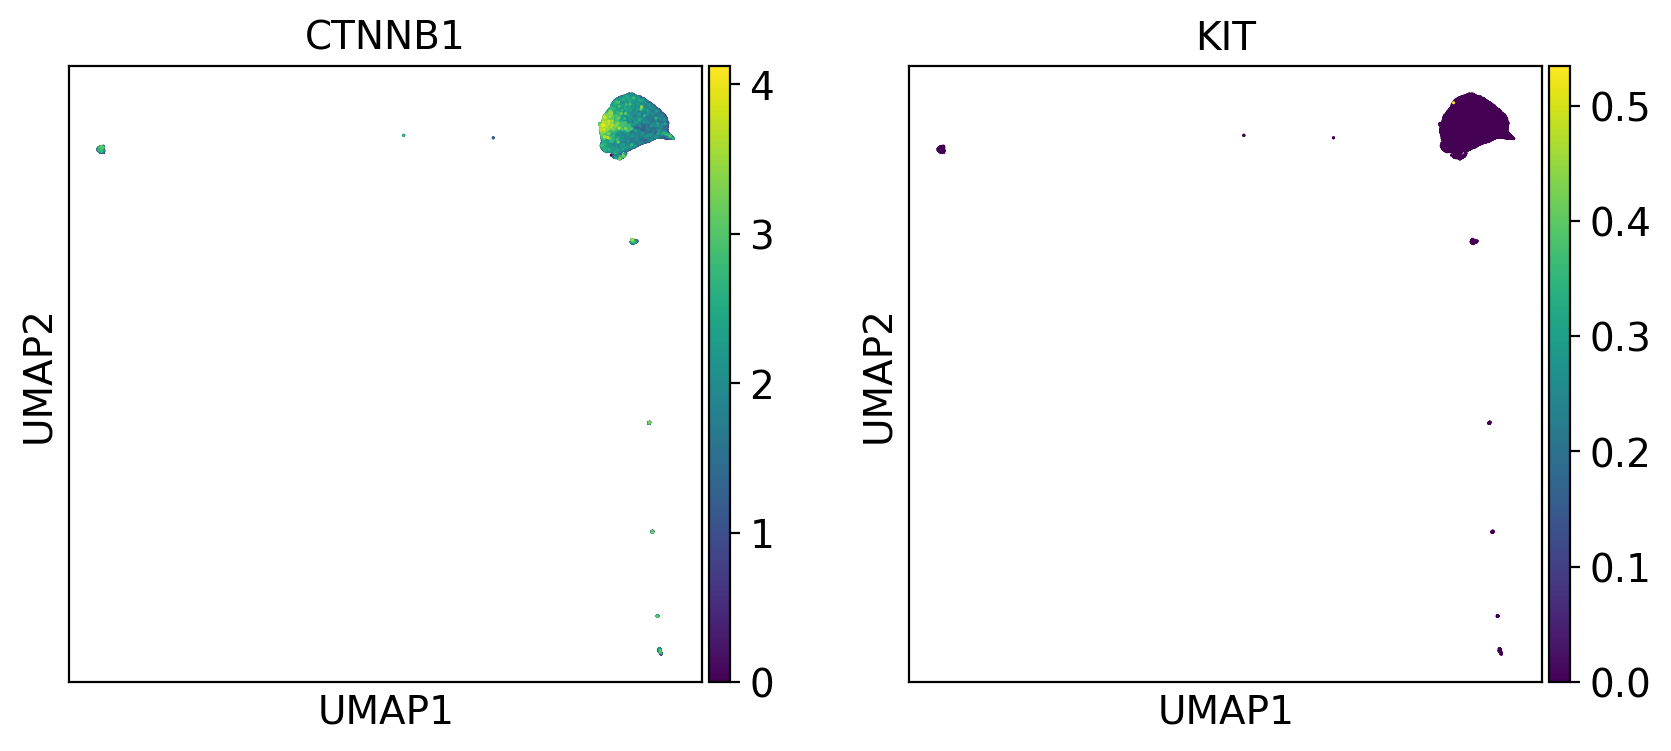

In [19]:
# Plot a few marker genes (sanity check)
markers = ["CTNNB1", "KIT"]
markers_corr = sc.pl.umap(corr_adata, color=markers, show=False)[0]
markers_corr.figure.savefig(out_stem + "_markers_corr.pdf",
                           dpi=300,
                           transparent=True,
                           bbox_inches="tight")
markers_raw = sc.pl.umap(raw_adata, color=markers, show=False)[0]
markers_raw.figure.savefig(out_stem + "_markers_raw.pdf",
                           dpi=300,
                           transparent=True,
                           bbox_inches="tight")

In [20]:
%%time
# Find clusters (lower resolution results in fewer clusters)
# Needs to happen on the re-projection subset
sc.tl.louvain(corr_umap, resolution=0.25)
sc.logging.print_memory_usage()

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:03.45) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Memory usage: current 11.59 GB, difference +0.00 GB
CPU times: user 6.16 s, sys: 252 ms, total: 6.41 s
Wall time: 3.49 s


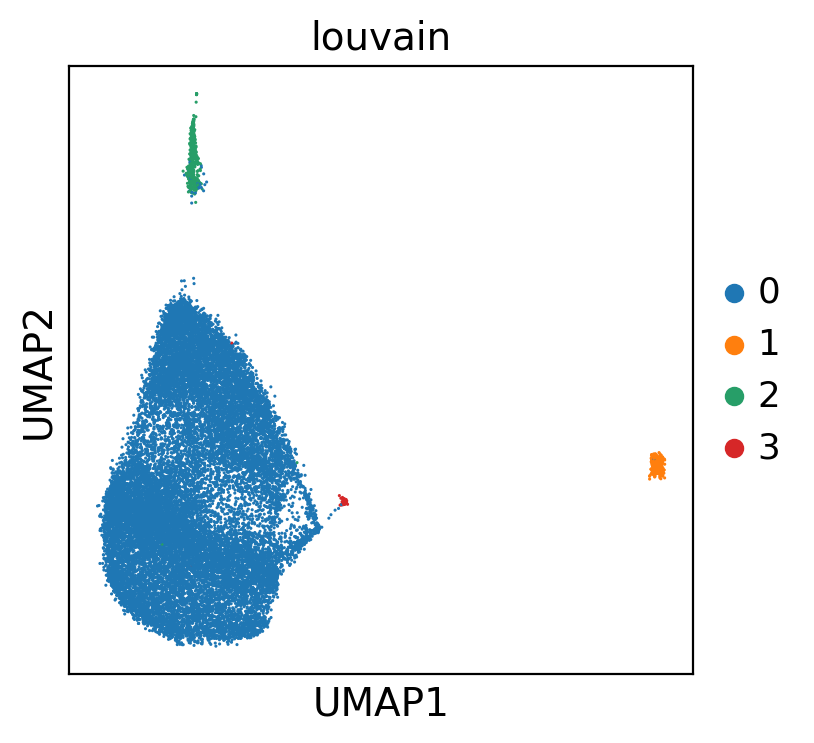

In [21]:
sc.pl.umap(corr_umap, color=["louvain"])

In [22]:
corr_adata.obs["ClusterID"] = corr_umap.obs["louvain"]

In [23]:
%%time
sc.tl.rank_genes_groups(corr_adata, "ClusterID")
sc.logging.print_memory_usage()

ranking genes
    finished (0:00:04.25) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
Memory usage: current 11.59 GB, difference +0.00 GB
CPU times: user 30.5 s, sys: 4.3 s, total: 34.8 s
Wall time: 4.26 s


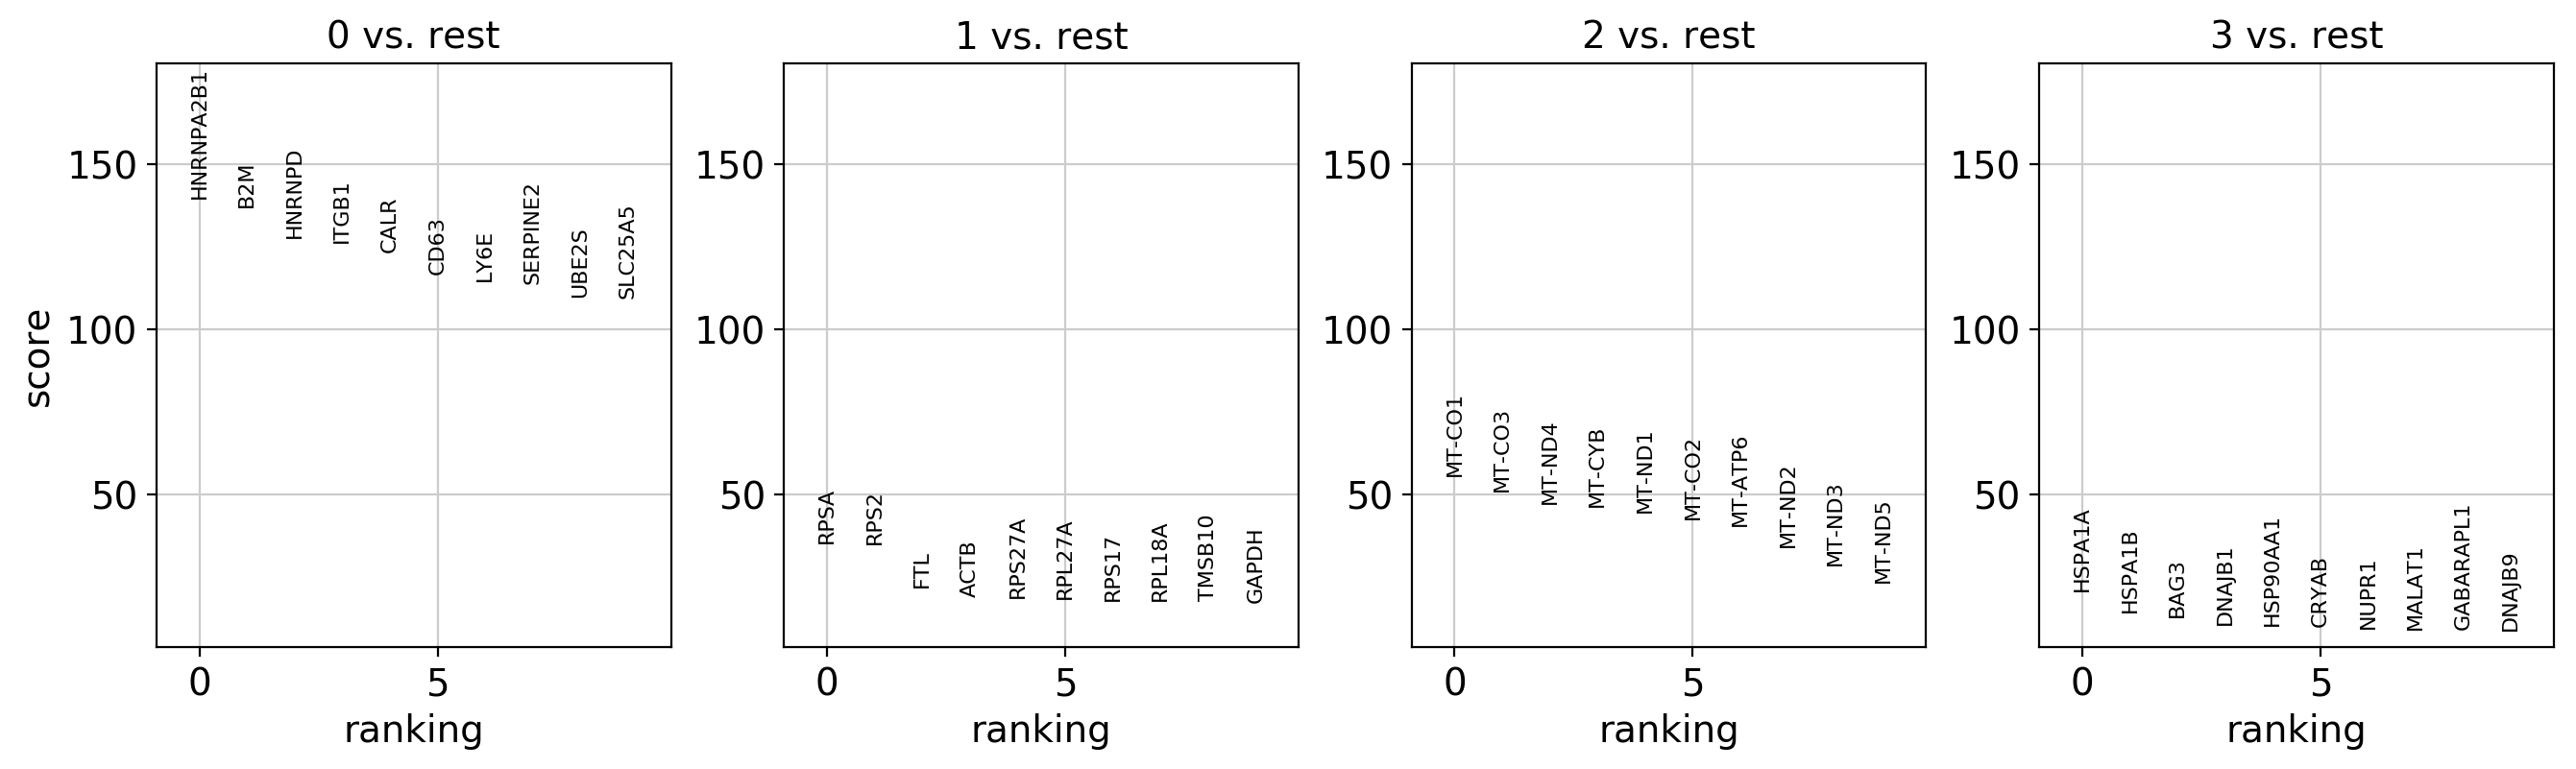

In [24]:
sc.pl.rank_genes_groups(corr_adata, n_genes=10)

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:02:35.72) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


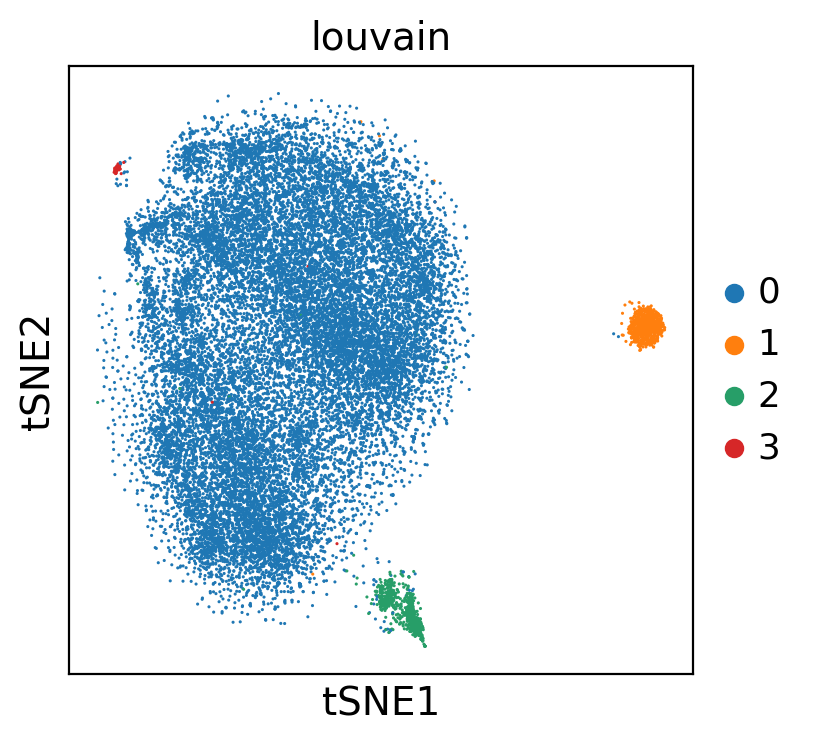

CPU times: user 24min 42s, sys: 15min 14s, total: 39min 57s
Wall time: 2min 36s


In [25]:
%%time
# Sanity check: cluster using tSNE
sc.tl.tsne(corr_umap, use_rep='X', n_jobs=16)
sc.pl.tsne(corr_umap, color="louvain")

In [26]:
corr_adata.obsm["X_tsne"] = corr_umap.obsm["X_tsne"]

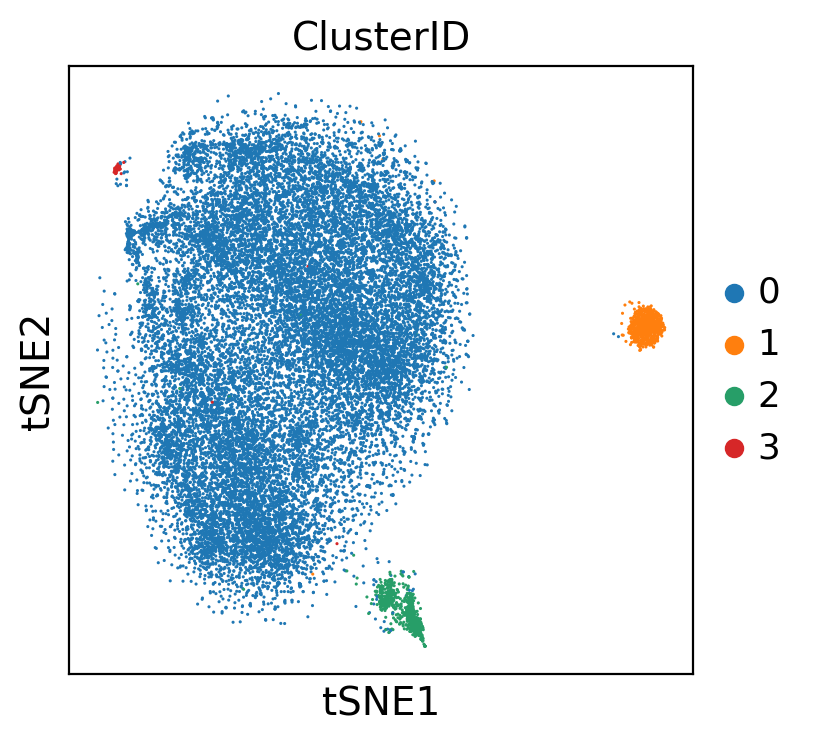

In [27]:
tsne = sc.pl.tsne(corr_adata, color=["ClusterID"], show=False)
tsne.figure.savefig(out_stem + "_tSNE.pdf",
                    dpi=300,
                    transparent=True,
                    bbox_inches="tight")

## Save as .loom

In [28]:
# Helper function to write all important data to Loom file
# This attempts to adhere to the Loom 2.0 conventions described here:
# http://linnarssonlab.org/loompy/conventions/index.html
def scanpyToLoom(adata, loomFilename, sampleName):
    assert loomFilename.endswith(".loom")
    # Write loom file to disk first
    adata.write_loom(loomFilename)
    # Connect to loom file and add data
    with loompy.connect(loomFilename) as l:
        # Set title (yes this references a global variable and is bad form)
        l.attrs["title"] = sampleName
        # Set gene names
        l.row_attrs["Gene"] = adata.var_names.to_native_types()
        # Set cell barcodes
        l.col_attrs["CellID"] = adata.obs_names.to_native_types()
        # Add embedding coordinates
        if "X_pca" in adata.obsm.keys():
            l.col_attrs["_PC1"] = adata.obsm["X_pca"][:, 0]
            l.col_attrs["_PC2"] = adata.obsm["X_pca"][:, 1]
        if "X_tsne" in adata.obsm.keys():
            l.col_attrs["_tSNE1"] = adata.obsm["X_tsne"][:, 0]
            l.col_attrs["_tSNE2"] = adata.obsm["X_tsne"][:, 1]
        if "X_umap" in adata.obsm.keys():
            l.col_attrs["_UMAP1"] = adata.obsm["X_umap"][:, 0]
            l.col_attrs["_UMAP2"] = adata.obsm["X_umap"][:, 1]
    print("Wrote {}".format(loomFilename))

In [29]:
# Save the raw data
corr_adata.write(results_file)
scanpyToLoom(corr_adata, out_stem + ".loom", "OCM-1A-HyPBase_scRNA")

Wrote ../output_and_analysis/reanalysis/OCM1A-HyPB.loom
